<a href="https://colab.research.google.com/github/akshat9000/Deep-Image-Matting-Implementation/blob/master/Deep_Image_Matting_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from tqdm import tqdm

In [0]:
train_path = glob.glob('/content/drive/My Drive/Colab Notebooks/train_fg/*.jpg')

In [0]:
train_alpha_path = glob.glob('/content/drive/My Drive/Colab Notebooks/train_alpha/*.jpg')

In [0]:
test_path = '/content/drive/My Drive/Colab Notebooks/test_fg/*.jpg'

In [0]:
test_alpha_path = '/content/drive/My Drive/Colab Notebooks/test_alpha/*.jpg'

In [0]:
gt_path = '/content/drive/My Drive/Colab Notebooks/train_fg/'

In [0]:
gt_alpha_path = '/content/drive/My Drive/Colab Notebooks/train_alpha/'

In [0]:
train = []
for item in sorted(train_path):
  train.append(item.split('/')[-1])

In [0]:
train_alpha = []
for item in sorted(train_alpha_path):
  train_alpha.append(item.split('/')[-1])

In [0]:
%matplotlib inline

In [0]:
import sklearn

In [0]:
from sklearn.metrics import mean_squared_error, f1_score, mean_absolute_error

In [0]:
height = 224
width = 224

In [0]:
batch_size = 8
epochs = 5
epsilon = 1e-6
epsilon_sqr = epsilon**2

In [0]:
num_pixels = height*width

In [0]:
X_train = np.zeros((len(train_path),height,width,4))
y_train = np.zeros((len(train_path),height,width,1))

In [0]:
def gen_trimap(alpha):
    alpha2 = alpha*255
    k_size = 10
    iterations = 20
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size, k_size))
    dilated = cv2.dilate(alpha2, kernel, iterations)
    eroded = cv2.erode(alpha2, kernel, iterations)
    trimap = np.zeros(alpha2.shape)
    trimap.fill(127)
    trimap[eroded >= 255] = 255
    trimap[dilated <= 0] = 0
    trimap = trimap/255
    return trimap

In [0]:
def create_dataset(X, y, gt_path, gt_list, alpha_path, alpha_list):
  for i in tqdm(range(len(gt_list))):
    first = cv2.imread('{}/{}'.format(gt_path,gt_list[i]))
    first = cv2.cvtColor(first,cv2.COLOR_BGR2RGB)
    first = cv2.resize(first,(height,width))
    first = np.asarray(first)
    first = first/(first.max())
    X[i,:,:,0:3] = first[:,:,:]
    alpha = cv2.imread('{}/{}'.format(alpha_path,alpha_list[i]))
    alpha = cv2.cvtColor(alpha,cv2.COLOR_BGR2GRAY)
    alpha = cv2.resize(alpha,(height,width))
    alpha = np.asarray(alpha)
    alpha = alpha/(alpha.max())
    trimap = gen_trimap(alpha)
    # trimap = np.expand_dims(trimap,axis=2)
    # print(trimap.shape)
    # trimap = cv2.cvtColor(trimap,cv2.COLOR_BGR2RGB)
    X[i,:,:,3] = trimap[:,:]
    alpha = np.expand_dims(alpha,axis=2)
    y[i,:,:,:] = alpha[:,:,:]
    # print(trimap.shape)

In [23]:
create_dataset(X_train,y_train,gt_path,train,gt_alpha_path,train_alpha)

100%|██████████| 431/431 [17:30<00:00,  2.44s/it]


In [0]:
import tensorflow as tf

In [17]:
import keras

Using TensorFlow backend.


In [0]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Lambda, Multiply

In [0]:
class Unpooling(Layer):

    def __init__(self, **kwargs):
        super(Unpooling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Unpooling, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs[:, 1]
        # print('x.shape: ' + str(K.int_shape(x)))
        bool_mask = Lambda(lambda t: K.greater_equal(t[:, 0], t[:, 1]),
                           output_shape=K.int_shape(x)[1:])(inputs)
        # print('bool_mask.shape: ' + str(K.int_shape(bool_mask)))
        mask = Lambda(lambda t: K.cast(t, dtype='float32'))(bool_mask)
        # print('mask.shape: ' + str(K.int_shape(mask)))
        x = Multiply()([mask, x])
        # print('x.shape: ' + str(K.int_shape(x)))
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2], input_shape[3], input_shape[4]

In [0]:
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Concatenate, Reshape, Lambda
from keras.models import Model

In [0]:
def build_encoder_decoder():
    # Encoder
    input_tensor = Input(shape=(height,width, 4))
    x = ZeroPadding2D((1, 1))(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_2')(x)
    orig_1 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_2')(x)
    orig_2 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_3')(x)
    orig_3 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_3')(x)
    orig_4 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_3')(x)
    orig_5 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Decoder
    # x = Conv2D(4096, (7, 7), activation='relu', padding='valid', name='conv6')(x)
    # x = BatchNormalization()(x)
    # x = UpSampling2D(size=(7, 7))(x)

    x = Conv2D(512, (1, 1), activation='relu', padding='same', name='deconv6', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_5)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_5)
    # print('origReshaped.shape: ' + str(K.int_shape(origReshaped)))
    xReshaped = Reshape(shape)(x)
    # print('xReshaped.shape: ' + str(K.int_shape(xReshaped)))
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    # print('together.shape: ' + str(K.int_shape(together)))
    x = Unpooling()(together)

    x = Conv2D(512, (5, 5), activation='relu', padding='same', name='deconv5', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_4)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_4)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)

    x = Conv2D(256, (5, 5), activation='relu', padding='same', name='deconv4', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_3)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_3)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)

    x = Conv2D(128, (5, 5), activation='relu', padding='same', name='deconv3', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_2)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_2)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)

    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv2', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_1)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_1)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)
    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv1', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)

    x = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='pred', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [0]:
def build_refinement(encoder_decoder):
    input_tensor = encoder_decoder.input

    input = Lambda(lambda i: i[:, :, :, 0:3])(input_tensor)

    x = Concatenate(axis=3)([input, encoder_decoder.output])
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='refinement_pred', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [24]:
model = build_encoder_decoder()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 4)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 226, 226, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 2368        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 226, 226, 64) 0           conv1_1[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer=sgd,loss='mse',metrics=['accuracy'])

In [0]:
from keras import optimizers

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [29]:
model.fit(X_train,y_train,batch_size=32,epochs=20,verbose=1)

Epoch 1/20
431/431 [==============================] - 60s 139ms/step - loss: 0.1255 - accuracy: 0.6906
Epoch 2/20
431/431 [==============================] - 28s 65ms/step - loss: 0.0641 - accuracy: 0.7700
Epoch 3/20
431/431 [==============================] - 28s 65ms/step - loss: 0.0541 - accuracy: 0.7772
Epoch 4/20
431/431 [==============================] - 28s 65ms/step - loss: 0.0462 - accuracy: 0.7822
Epoch 5/20
431/431 [==============================] - 28s 65ms/step - loss: 0.0419 - accuracy: 0.7860
Epoch 6/20
431/431 [==============================] - 28s 65ms/step - loss: 0.0411 - accuracy: 0.7867
Epoch 7/20
431/431 [==============================] - 28s 64ms/step - loss: 0.0397 - accuracy: 0.7884
Epoch 8/20
431/431 [==============================] - 28s 65ms/step - loss: 0.0390 - accuracy: 0.7892
Epoch 9/20
431/431 [==============================] - 28s 64ms/step - loss: 0.0413 - accuracy: 0.7872
Epoch 10/20
431/431 [==============================] - 28s 64ms/step - loss: 0.03

In [0]:
test = glob.glob('/content/drive/My Drive/Colab Notebooks/test_fg/')

In [0]:
test_alp = glob.glob('/content/drive/My Drive/Colab Notebooks/test_alpha/*.jpg')

In [0]:
X_test = np.zeros((15,height,width,4))

In [0]:
for i in range(15):
  X_test[i,:,:,:] = X_train[i,:,:,:]

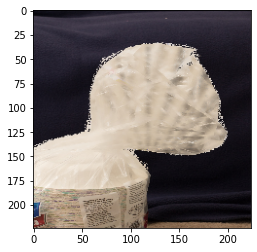

In [32]:
plt.imshow(X_test[1,:,:,0:3])

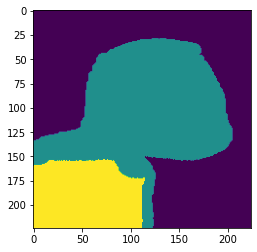

In [33]:
plt.imshow(X_test[1,:,:,3])

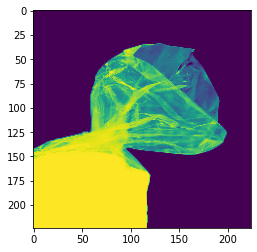

In [38]:
plt.imshow(y_train[1,:,:,0])

In [0]:
result = model.predict(X_train)

In [42]:
result.shape

(431, 224, 224, 1)

In [0]:
refine = build_refinement(model)

In [40]:
refine.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 4)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 226, 226, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 2368        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 226, 226, 64) 0           conv1_1[0][0]                    
____________________________________________________________________________________________

In [0]:
import keras.backend as K

In [0]:
def overall_loss(y_true,y_pred):
  # diff = y_pred - y_true
  mask = y_true[:,:,:,:]
  alpha = y_pred[:,:,:,:]
  diff = alpha - mask
  r = K.sum(K.sqrt((diff**2)+epsilon_sqr))/(num_pixels+epsilon+batch_size)

In [44]:
result.shape

(431, 224, 224, 1)

In [50]:
for i in tqdm(range(len(X_train))):
  # X_train2[i,:,:,0:3] = X_train[i,:,:,0:3]
  X_train2[i,:,:,3] = result[i,:,:,0]

100%|██████████| 431/431 [00:00<00:00, 3542.29it/s]


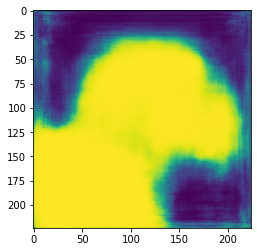

In [55]:
plt.imshow(X_train2[1,:,:,3])

In [52]:
for i in tqdm(range(len(X_train))):
  X_train2[i,:,:,0:3] = X_train[i,:,:,0:3]

100%|██████████| 431/431 [00:00<00:00, 1690.10it/s]


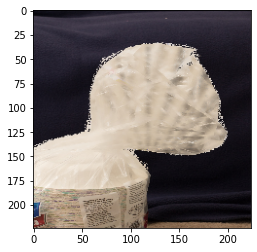

In [54]:
plt.imshow(X_train2[1,:,:,0:3])

In [135]:
refine.compile(optimizer=sgd,loss=overall_loss,metrics=['accuracy'])     #Unable to implement overall loss function

AttributeError: ignored

In [0]:
refine.compile(optimizer=sgd,loss='mse',metrics=['accuracy'])

In [70]:
refine.fit(X_train,y_train,batch_size=batch_size,epochs=20,verbose=1)

Epoch 1/20
431/431 [==============================] - 58s 135ms/step - loss: 0.0583 - accuracy: 0.7746
Epoch 2/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0361 - accuracy: 0.7924
Epoch 3/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0355 - accuracy: 0.7938
Epoch 4/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0301 - accuracy: 0.7982
Epoch 5/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0294 - accuracy: 0.7988
Epoch 6/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0281 - accuracy: 0.7996
Epoch 7/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0298 - accuracy: 0.7990
Epoch 8/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0287 - accuracy: 0.8000
Epoch 9/20
431/431 [==============================] - 58s 134ms/step - loss: 0.0279 - accuracy: 0.8002
Epoch 10/20
431/431 [==============================] - 58s 134ms/step - l

In [0]:
results2 = refine.predict(X_train)

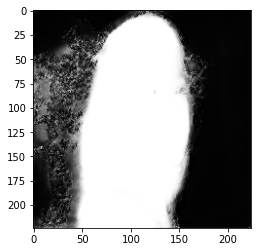

In [91]:
plt.imshow(results2[278,:,:,0],cmap='gray')

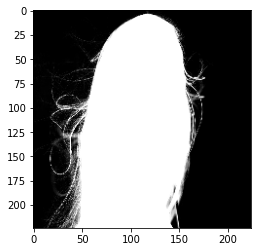

In [89]:
plt.imshow(y_train[278,:,:,0],cmap='gray')

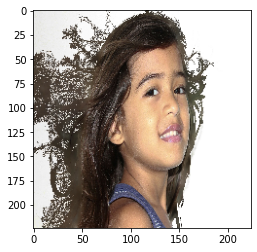

In [90]:
plt.imshow(X_train[278,:,:,0:3])

In [96]:
results2.shape

(431, 224, 224, 1)

In [0]:
def compute_mse(y_true,y_pred):
  summation = []
  for i in range(len(y_true)):
    summation.append((((y_true[i]-y_pred[i])**2).sum())/(num_pixels*batch_size))
  return sum(summation)

In [112]:
compute_mse(y_train,results2)

1.1421324412976765

In [0]:
def compute_sad(y_true, y_pred):
  summation = []
  for i in range(len(y_true)):
    diff = np.abs(y_true[i]-y_pred[i])
    summation.append((diff.sum())/(batch_size*1000))
  return sum(summation)

In [115]:
compute_sad(y_train,results2)

160.44680904806347

In [0]:
def plot_random_5(X_true, y_true, y_pred, offset=0,hop=3):
  f, axarr = plt.subplots(5,3,figsize=(15,15))
  # f.set_figheight(15)
  # f.set_figwidth(15)
  # f.figsize=(16, 16)
  # for i in range(5):
  #   axarr[i,0] = plt.imshow(X_true[i+offset,:,:,0:3])
  #   axarr[i,1] = plt.imshow(y_true[i+offset,:,:,0])
  #   axarr[i,2] = plt.imshow(y_pred[i+offset,:,:,0])
  # # plt.show()
  axarr[0,0].imshow(X_true[offset+hop,:,:,0:3])
  axarr[0,1].imshow(y_true[offset+hop,:,:,0],cmap='gray')
  axarr[0,2].imshow(y_pred[offset+hop,:,:,0],cmap='gray')
  axarr[1,0].imshow(X_true[offset+1+hop,:,:,0:3])
  axarr[1,1].imshow(y_true[offset+1+hop,:,:,0],cmap='gray')
  axarr[1,2].imshow(y_pred[offset+1+hop,:,:,0],cmap='gray')
  axarr[2,0].imshow(X_true[offset+2+hop,:,:,0:3])
  axarr[2,1].imshow(y_true[offset+2+hop,:,:,0],cmap='gray')
  axarr[2,2].imshow(y_pred[offset+2+hop,:,:,0],cmap='gray')
  axarr[3,0].imshow(X_true[offset+3+hop,:,:,0:3])
  axarr[3,1].imshow(y_true[offset+3+hop,:,:,0],cmap='gray')
  axarr[3,2].imshow(y_pred[offset+3+hop,:,:,0],cmap='gray')
  axarr[4,0].imshow(X_true[offset+4+hop,:,:,0:3])
  axarr[4,1].imshow(y_true[offset+4+hop,:,:,0],cmap='gray')
  axarr[4,2].imshow(y_pred[offset+4+hop,:,:,0],cmap='gray')

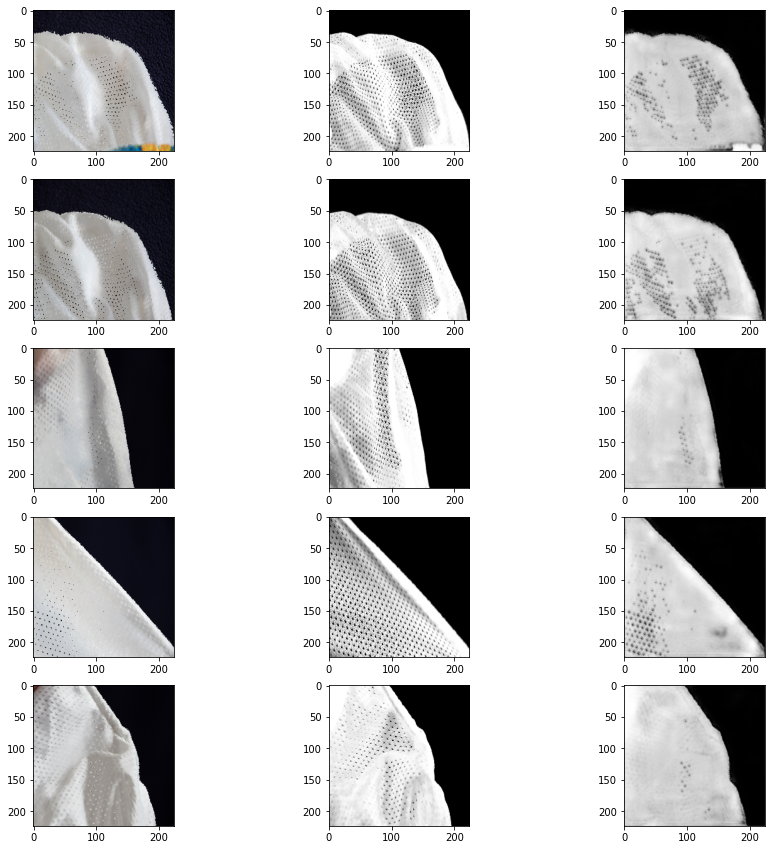

In [177]:
plot_random_5(X_train,y_train,results2,15,25)

***SUMMARY***
* Built Encoder_Decoder
* Built and connected Refinement stage
* Number of epochs used for training = 20
* Batch size used for training = 8
* Number of samples used for training = 431
* Number of samples used for testing = 431 (same samples as training)
* Validation split used = No
* Dropout used = No
* Optimizer used = SGD
* Loss function used = MSE
* SAD error = 160.44680904806347
* MSE error = 1.1421324412976765

Need more samples and better computer rig for better results